In [1]:
import numpy as np
import matplotlib.pyplot as plt

class GridWorld:
    def __init__(self, rows=7, cols=7, goal=(5,5), forbidden=[(1,4),(2,3),(2,2),(3,3),(4,5)]):
        self.rows = rows
        self.cols = cols
        self.goal = goal
        self.forbidden = set(forbidden)
        self.actions = {
            0: (-1, 0),  # up
            1: (0, 1),   # right
            2: (1, 0),   # down
            3: (0, -1),   # left
            4: (0, 0)    # stay
        }

    def step(self, state, action):
        """输入 state=(r,c), action，返回 (next_state, reward)"""
        r, c = state
        dr, dc = self.actions[action]
        new_r, new_c = r + dr, c + dc

        # 撞墙
        if not (0 <= new_r < self.rows and 0 <= new_c < self.cols):
            return state, -5

        # 禁区
        if (new_r, new_c) in self.forbidden:
            return (new_r, new_c), -10

        # 到达目标
        if (new_r, new_c) == self.goal:
            return (new_r, new_c), 10

        # 普通移动
        return (new_r, new_c), 0
    
    def get_states(self):
        """返回所有可用状态"""
        states = []
        for r in range(self.rows):
            for c in range(self.cols):
                states.append((r, c))
        return states
    
    
    def render(self, policy=None, values=None, cell_size=1.2):
        """可视化：白色=正常, 黄=禁区, 蓝=goal，cell_size=每格大小"""
        fig, ax = plt.subplots(figsize=(self.cols * cell_size, self.rows * cell_size))
        
        grid = np.ones((self.rows, self.cols, 3))  # 默认白色
        for (r, c) in self.forbidden:
            grid[r, c] = [1, 1, 0]  # 黄色
        gr, gc = self.goal
        grid[gr, gc] = [0, 0, 1]  # 蓝色

        # 关键：加上 origin="upper"，确保坐标和数组一致
        ax.imshow(grid, origin="upper")

        # 如果有值函数
        if values is not None:
            for (r, c), v in values.items():
                ax.text(c, r + 0.25, f"{v:.1f}", 
                        ha='center', va='top', color='black', fontsize=12)

        # 如果有策略
        if policy is not None:
            arrows = {0: "↑", 1: "→", 2: "↓", 3: "←", 4: "O"}
            for (r, c), a in policy.items():
                ax.text(c, r - 0.2, arrows[a], ha='center', va='center',color='red', fontsize=16, fontweight='bold')

        # 设置网格
        ax.set_xticks(np.arange(-0.5, self.cols, 1))
        ax.set_yticks(np.arange(-0.5, self.rows, 1))
        ax.grid(which="both", color="black", linewidth=1)

        # 去掉刻度
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.show()

In [2]:
def value_iteration(env, gamma=0.9, threshold=1e-4, max_iterations=1000):
    V = {s: 0 for s in env.get_states()}# 初始化价值函数
    policy = {s: 0 for s in env.get_states()}  # 初始化策略
    iterations = 0
    deltas = []  # 记录每次迭代的delta
    
    for it in range(max_iterations):
        delta = 0  # 记录本次迭代中，所有state的最大变化量
        # 遍历所有状态
        for s in env.get_states():
            action_values = {a: 0 for a in env.actions.keys()} # 存储每个动作的价值
            # 计算该state下所有动作的价值,并选择最大的
            for a in env.actions.keys():
                next_s, r = env.step(s, a)
                action_values[a] = r + gamma * V[next_s]
            best_a = max(action_values, key=action_values.get)
            best_value = action_values[best_a]
            policy[s] = best_a # Policy update
            old_value = V[s]
            V[s] = best_value  # Value update
            delta = max(delta, abs(V[s] - old_value)) #记录这个state的变化量是否最大
        
        deltas.append(delta)  # 记录本轮的最大变化量

        if delta < threshold: # 检查收敛,如果最大变化量小于阈值，认为收敛
            iterations = it + 1
            break
        else:
            iterations = max_iterations
    
    # 绘制收敛曲线
    plt.plot(deltas, marker="o")
    plt.xlabel("Iteration")
    plt.ylabel("Delta (max change in V)")
    plt.title("Value Iteration Convergence")
    plt.grid(True)
    plt.show()

    return policy, V, iterations

所有状态： [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6)]
状态数： 49


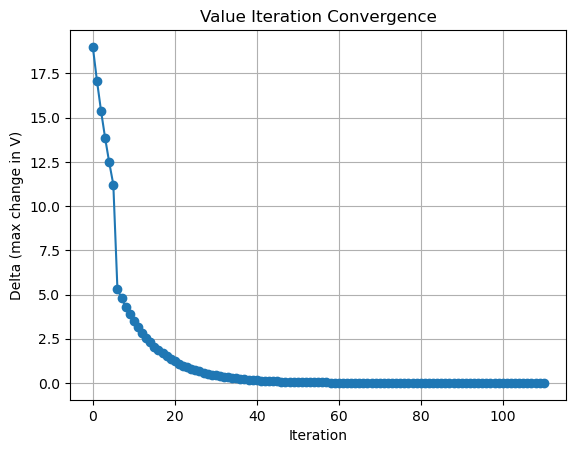

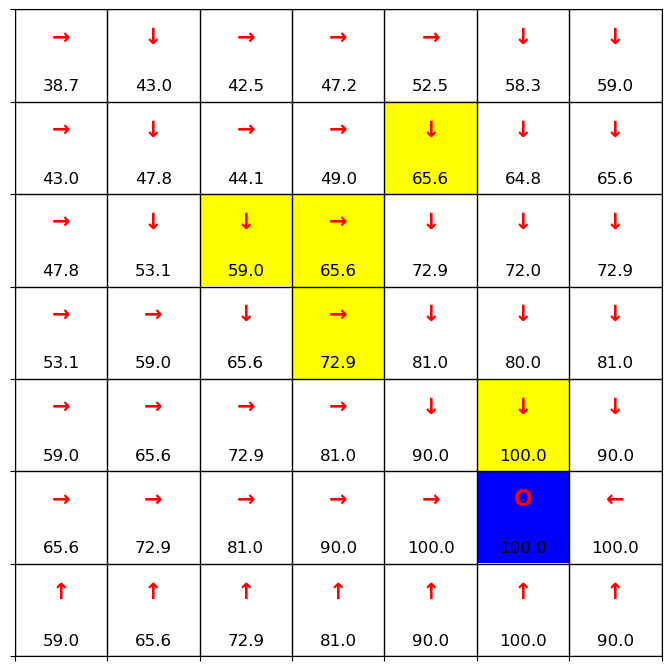

Value Iteration converged in 111 iterations.


In [3]:
# 运行值迭代
env = GridWorld()

states = env.get_states()
print("所有状态：", states)
print("状态数：", len(states))

policy, V, iterations = value_iteration(env)
env.render(policy, V)
print(f"Value Iteration converged in {iterations} iterations.")